In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.model_zoo as model_zoo

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib import pyplot
from scipy.interpolate import spline

import time
import os

In [122]:
__all__ = ['ResNet', 'resnet18']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dropRate=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.downsample = downsample
        self.stride = stride
        self.droprate = dropRate

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [123]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "C:\\Users\\JBWV9182\\Desktop\\train_vega"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

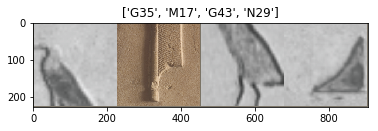

In [124]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [131]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # récupère les poids à chaque itération
                    # print(torch.sum(model.fc.weight.data))

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, 'vega_model.pt')
    return model

In [126]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j]) #cpu

            if images_so_far == num_images:
                return

In [127]:
model_conv = resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc1 = nn.Linear(num_ftrs, 512)
model_ft.fc2 = nn.Linear(model_ft.fc1.in_features, 256)
model_ft.fc = nn.Linear(model_ft.fc2.in_features, 88) #Add a layer

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

#SGD
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001)

#Adam
optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.0001)

#Adagrad
#optimizer_ft = optim.Adagrad(model_ft.parameters(), lr = 0.0001)

#RMSProp
#optimizer_ft = optim.RMSprop(model_ft.parameters(), lr = 0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [128]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


KeyboardInterrupt: 

c:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
c:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  from ipykernel import kernelapp as app
c:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()
c:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


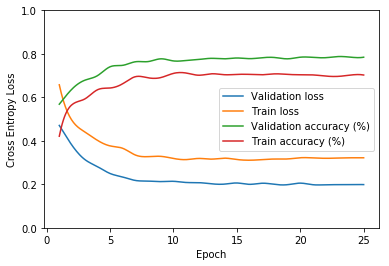

In [130]:
#PLOTS
epoch = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
val_loss = np.array(val_loss)
val_acc = np.array(val_acc)
train_loss = np.array(train_loss)
train_acc = np.array(train_acc)


pyplot.ylabel('Cross Entropy Loss')
pyplot.xlabel('Epoch')
pyplot.ylim([0,1])

xnew = np.linspace(epoch.min(), epoch.max(), 300)
v_loss = spline(epoch, val_loss, xnew)
v_acc = spline(epoch, val_acc, xnew)
t_loss = spline(epoch, train_loss, xnew)
t_acc = spline(epoch, train_acc, xnew)

plt.plot(xnew, v_loss, label="Validation loss")
pyplot.legend()
plt.plot(xnew, t_loss, label="Train loss")
pyplot.legend()
plt.plot(xnew, v_acc, label="Validation accuracy (%)")
pyplot.legend()
plt.plot(xnew, t_acc, label="Train accuracy (%)")
pyplot.legend()

plt.show()

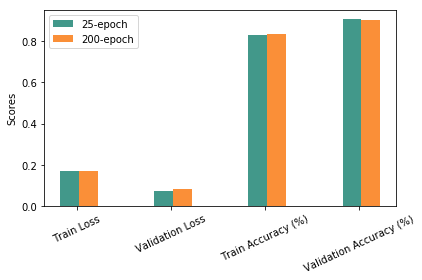

In [108]:
# BAR CHART
n_groups = 4
values_25 = (0.171958441358, 0.0716477077045, 0.827030812325, 0.905011219147)
values_200 = (0.17189152375990605, 0.08264696504433118, 0.8315826330532213, 0.8990276738967838)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
 
rects1 = plt.bar(index, values_25, bar_width,
                 alpha=opacity,
                 color='xkcd:blue green',
                 label='25-epoch')
 
rects2 = plt.bar(index + bar_width, values_200, bar_width,
                 alpha=opacity,
                 color='xkcd:orange',
                 label='200-epoch')
 
plt.ylabel('Scores')
plt.xticks(index + 0.08, ('Train Loss', 'Validation Loss', 'Train Accuracy (%)', 'Validation Accuracy (%)'), rotation=25)
plt.legend()

plt.tight_layout()
plt.show()

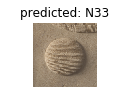

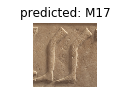

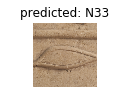

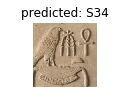

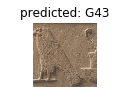

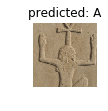

In [12]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [17]:
#model_ft.state_dict()

OrderedDict([('conv1.weight', 
              (0 ,0 ,.,.) = 
               -1.6686e-02 -1.3129e-02 -8.9909e-03  ...   5.0127e-02  1.1598e-02 -1.8310e-02
                7.4725e-03  4.6767e-03 -1.1496e-01  ...  -2.7648e-01 -1.3259e-01 -9.9280e-04
               -1.1264e-02  5.3995e-02  2.8967e-01  ...   5.1472e-01  2.5235e-01  5.8731e-02
                               ...                   ⋱                   ...                
               -3.5535e-02  7.9969e-03  6.4753e-02  ...  -3.3783e-01 -4.2773e-01 -2.6472e-01
                2.1939e-02  3.2865e-02  5.5732e-02  ...   4.0869e-01  3.8722e-01  1.5971e-01
               -2.2293e-02 -1.2066e-02 -3.0878e-02  ...  -1.5548e-01 -8.7834e-02 -1.1764e-02
              
              (0 ,1 ,.,.) = 
               -1.7127e-02 -3.2684e-02 -4.0663e-02  ...   2.6688e-02 -3.7560e-03 -3.0437e-02
                4.3460e-02  2.9997e-02 -1.0802e-01  ...  -3.1722e-01 -1.6276e-01 -4.9421e-03
               -3.8416e-03  9.4580e-02  3.9779e-01  ...   7

In [10]:
#print(model_ft)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo